# Testing `pycic`

In [1]:
import numpy as np
import pycic

import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Testing Power Spectrum Objects

Classes related to power spectrum are 

1. `cicPowerSpectrum` for linear matter power
2. `cicMeasPowerSpectrum` for measured count-in-cells power spectrum

### Linear Power Spectrum Object

It is used for

1. Storing the linear power spectrum data and get interpolated values.
2. Calculate variances.

Linear variance is found by integrating the power spectrum. A spherical top-hat filter is used for smoothing

$$ \sigma_{\rm lin}^2(r) = \frac{1}{2\pi^2} \int_0^{\infty} k^2 P(k) W_{\rm th}^2(kr) {\rm d}k $$

Power spectrum is normalised by setting $\sigma_{\rm lin}(8) = \sigma_8$.

In [2]:
# create a linear power spectrum object from power spectrum data:
# cosmology: h = 0.7, Om0 = 0.3, Ob0 = 0.05 Tcmb0 = 2.725, ns = 1.
# k range: 1e-8 to 1e+8
# file struct.: ln(k), ln(pk_unnorm)
pk_tab = np.loadtxt("./data/power.csv", delimiter = ',')

pso    = pycic.cicPowerSpectrum(pk_tab)

# normalise the power with sigma8 = 0.8
pso.normalise(0.8)

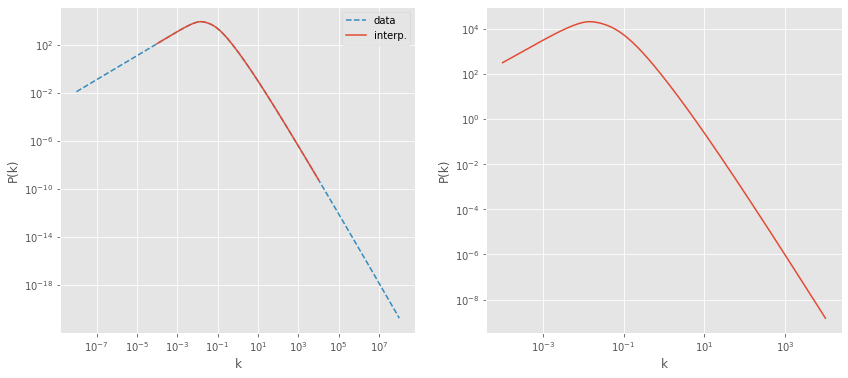

In [3]:
# power calculation from object:
k  = np.logspace(-4, 4, 201)
pk = pso(np.log(k), False) # un-normalized
qk = pso(np.log(k), )      # normalized


fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))

ax1.loglog()
ax1.plot(np.exp(pso.data[:, 0]), np.exp(pso.data[:,1]), '--', color = 'C1', label = 'data')
ax1.plot(k, pk, '-', color = 'C0', label = 'interp.')
ax1.set_xlabel('k'); ax1.set_ylabel('P(k)'); ax1.legend()

ax2.loglog()
ax2.plot(k, qk, '-', color = 'C0',)
ax2.set_xlabel('k'); ax2.set_ylabel('P(k)')

plt.show()

In [4]:
# linear variance calculation:
pso.var(8.) # var(8) = 0.8^2 = 0.64

0.6400000000000001

In [5]:
# cell variance calculation:
pso.cicvar(2.)

6.490855375490081

### Measured Power Spectrum Object

It is used for calculating the measured power spectrum in a cell, $P_{meas}$. 

$$ P_{meas}({\bf k}) = \sum_{\bf n} P({\bf k} + 2k_N{\bf n}) W^2({\bf k} + 2k_N{\bf n}), \vert {\bf k} \vert \le k_N$$

where $W$ is the mass assignment function and ${\bf n} \in \Z^3$. Practically $\vert {\bf n} \vert < 3$ are used. For other k vectors, a power law continuation of the form $P({\bf k}) = a + b \vert {\bf k} \vert^c$ is used.

Multiplying with the log field bias factor, $b_A^2$ will give the power for the log field, $P_{A, meas}(k)$.

In [6]:
def linpower(k):
    """ return the normalised linear power """
    return pso.power(np.log(k), normalise = True)

# let kn = 2 h/Mpc
kn  = 2.

mps = pycic.cicMeasPowerSpectrum(linpower, kn = kn)

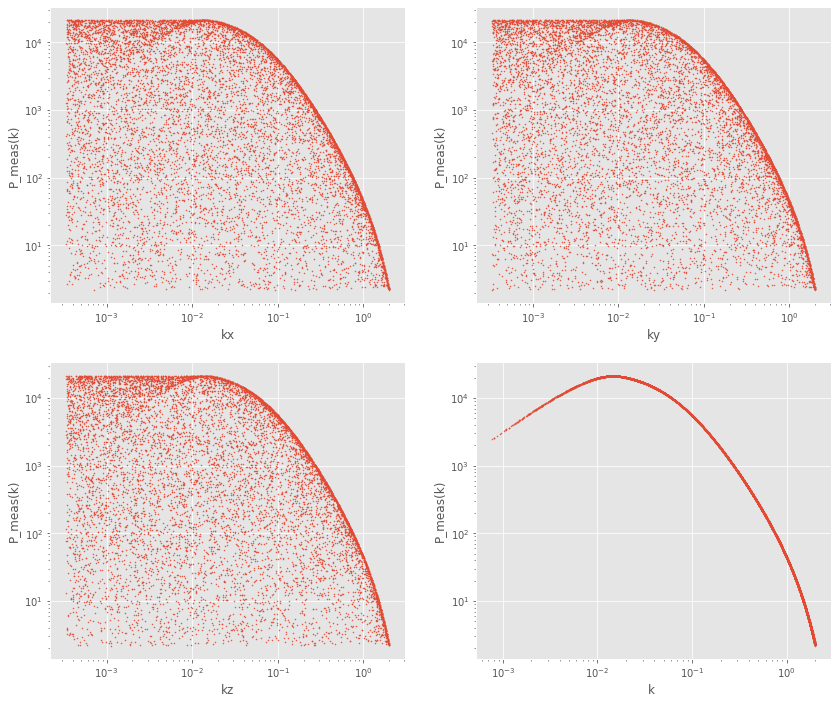

In [7]:
# k vectors with length < kn
kvec = np.exp(np.random.uniform(-8, np.log(kn), (10000, 3)))
klen = np.sqrt(np.sum(kvec**2, axis = -1))
mask = np.where(klen < kn, )[0]

kvec, klen = kvec[mask, :], klen[mask]

# power spectrum for k < kn
mpk = mps.fbound(kvec)

fig, axs = plt.subplots(2, 2, figsize = (14, 12))

for _axi, _ki, _i in zip(axs.flatten(), [*kvec.T, klen], "xyz "):
    _axi.loglog(_ki, mpk, 'o', ms = .5)
    _axi.set_xlabel('k' + _i); _axi.set_ylabel('P_meas(k)')

plt.show()


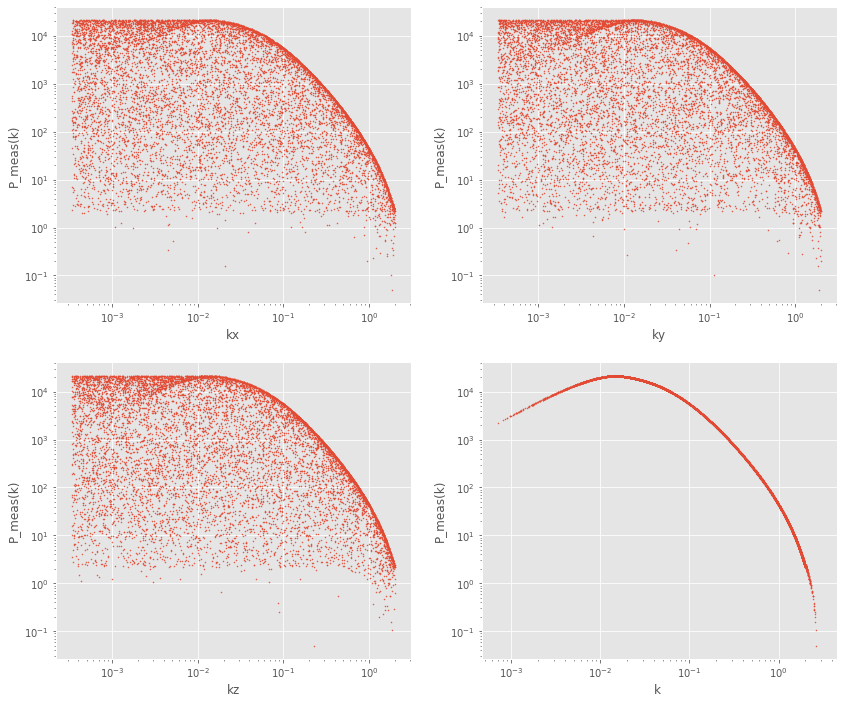

In [8]:
# all k vectors
kvec = np.exp(np.random.uniform(-8, np.log(kn), (10000, 3)))
klen = np.sqrt(np.sum(kvec**2, axis = -1))

# full power spectrum (power law contd.)
mpk = mps(kvec)

fig, axs = plt.subplots(2, 2, figsize = (14, 12))

for _axi, _ki, _i in zip(axs.flatten(), [*kvec.T, klen], "xyz "):
    _axi.loglog(_ki, mpk, 'o', ms = .5)
    _axi.set_xlabel('k' + _i); _axi.set_ylabel('P_meas(k)')

plt.show()

## Testing the Cosmology Object

Class `cicCosmology` is used to store a cosmology model, which can be used for calculating linear power spectrum, $E(z)$, growth factor and rate etc. 

In [10]:
c = pycic.cicCosmology(Om0 = 0.3, Ode0 = 0.7, h = 0.7, ns = 1., pk_tab = pk_tab)
c

Cosmology(Om0 = 0.3, Ode0 = 0.7, h = 0.7, ns = 1.0)

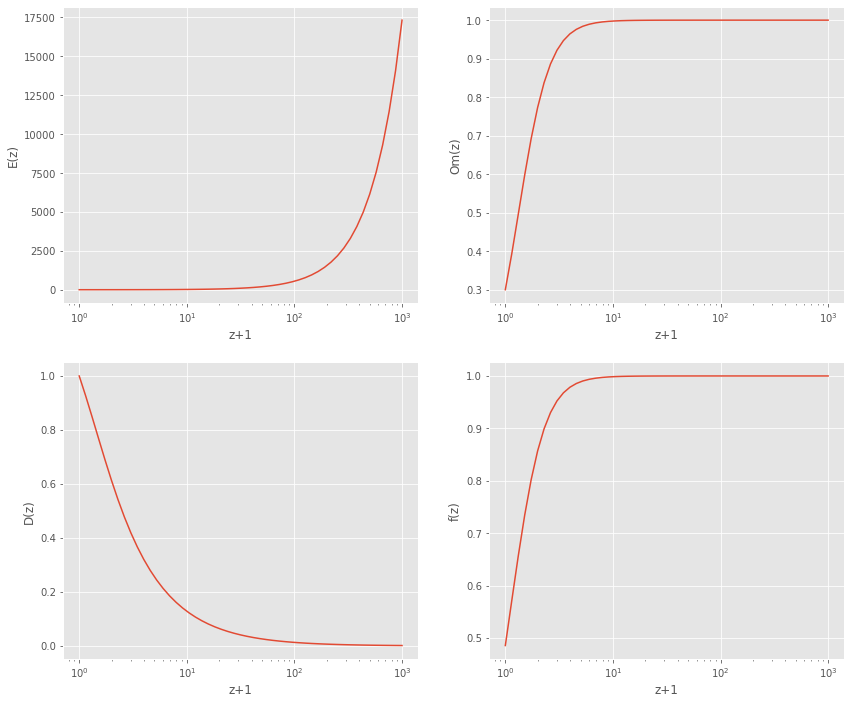

In [19]:
# some useful functions of redshift z

zp1 = np.logspace(0, 3, 51)

fzs = {
            'E' : c.Ez(zp1-1),  # E(z) = H(z) / H0
            'Om': c.Omz(zp1-1), # matter density parameter
            'D' : c.Dz(zp1-1),  # linear growth factor
            'f' : c.fz(zp1-1),  # linear growth rate, ~ Omz^0.6
      }


fig, axs = plt.subplots(2, 2, figsize = (14, 12))

for _axi, _fz, _name in zip(axs.flatten(), fzs.values(), fzs.keys()):
    _axi.semilogx(zp1, _fz, '-', )
    _axi.set_xlabel('z+1'); _axi.set_ylabel(_name + '(z)')

plt.show()

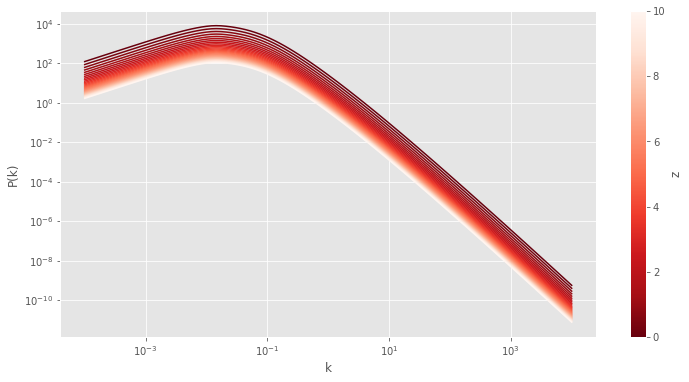

In [43]:
# power spectrum:

k  = np.logspace(-4, 4, 101)
zs = np.linspace(0., 10., 31)

# creating a colormap
from matplotlib import colors, cm 
cmap = cm.ScalarMappable(
                            norm = colors.Normalize(zs.min(), zs.max(), ),
                            cmap = cm.Reds_r
                        )
cmap.set_array([])

fig, ax1 = plt.subplots(1, 1, figsize = (12, 6))

ax1.loglog()
for z in zs:
    ax1.plot(k, c.power(k, z), '-', color = cmap.to_rgba(z))
ax1.set_xlabel('k'); ax1.set_ylabel('P(k)')

cax = plt.colorbar(cmap)
cax.ax.set_ylabel('z')

plt.show()

## Testing One-Point Distribution

One point distribution function for $\delta$ implemented in `pycic` is the function given in Repp & Szapudi 2018 (arXiv:1705.08015v2). For the log field $A = \log(\delta+1)$, it is given by

$$ \mathcal{P}(A) = \frac{1}{\sigma} t(A)^{1 + \xi} \exp[-t(A)] $$

where

$$ t(A) = \left( 1 + \frac{A - \mu}{\sigma} \xi \right)^{-1/\xi} $$

$\mu, \sigma, \xi$ are the location, scale and shape parameters. 

In [44]:
pdf = pycic.cicDeltaDistribution(0., 2., model = c)

NotImplementedError: 